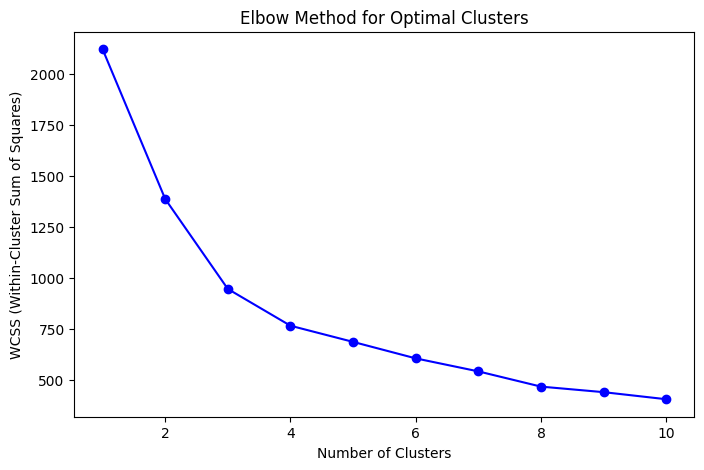

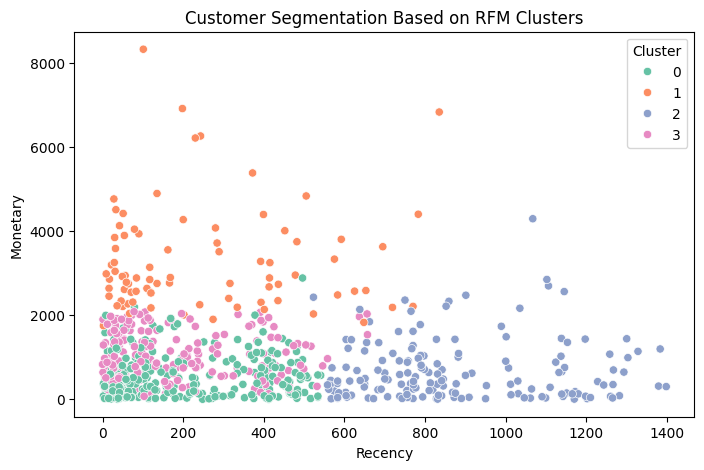

            Recency  Frequency     Monetary
Cluster                                    
1        248.768293   4.268293  3284.314915
3        178.562500   3.586538  1039.613116
2        872.969697   1.600000   674.133782
0        209.250000   1.603175   576.247500


In [1]:
# Import required libraries
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data (replace 'file_path' with the actual path)
file_path = 'Super_Store_data.csv'
data = pd.read_csv(file_path, encoding='ISO-8859-1')

# Preprocess data
data['Order Date'] = pd.to_datetime(data['Order Date'])

# Create the RFM table
current_date = data['Order Date'].max()
rfm_table = data.groupby('Customer ID').agg({
    'Order Date': lambda x: (current_date - x.max()).days,  # Recency
    'Order ID': 'nunique',  # Frequency: Number of unique orders
    'Sales': 'sum'  # Monetary: Total spending
}).rename(columns={'Order Date': 'Recency', 'Order ID': 'Frequency', 'Sales': 'Monetary'})

# Step 1: Scale the RFM data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_table)

# Step 2: Elbow method to find the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.show()

# Step 3: Apply K-Means with the optimal number of clusters (replace with the chosen number, e.g., 4)
optimal_clusters = 4  # Adjust this based on the elbow plot
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
rfm_table['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Step 4: Visualize the clusters
plt.figure(figsize=(8, 5))
sns.scatterplot(x='Recency', y='Monetary', hue='Cluster', data=rfm_table, palette='Set2')
plt.title('Customer Segmentation Based on RFM Clusters')
plt.show()

# Step 5: Analyze each cluster (optional)
cluster_analysis = rfm_table.groupby('Cluster').mean().sort_values(by='Monetary', ascending=False)
print(cluster_analysis)


In [2]:
import joblib  # For saving and loading the model

# Step 1: Train the KMeans model on the scaled RFM data
optimal_clusters = 4  # Use the optimal number from earlier
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(rfm_scaled)  # Train the model

# Step 2: Save the trained model
joblib.dump(kmeans, 'kmeans_rfm_model.pkl')  # Saving the model

# Save the scaler as well since we need to preprocess future data in the same way
joblib.dump(scaler, 'scaler_rfm.pkl')

print("Model and scaler saved successfully!")

Model and scaler saved successfully!


In [6]:
# Step 1: Load the saved model and scaler
kmeans_loaded = joblib.load('kmeans_rfm_model.pkl')
scaler_loaded = joblib.load('scaler_rfm.pkl')

# Step 2: Preprocess the new data (similar to how we did for the original RFM data)
new_data = pd.read_csv('synthetic_customer_data.csv', encoding='ISO-8859-1')
new_data['Order Date'] = pd.to_datetime(new_data['Order Date'])

# Create RFM table for the new data
current_date = new_data['Order Date'].max()
rfm_new = new_data.groupby('Customer ID').agg({
    'Order Date': lambda x: (current_date - x.max()).days,
    'Order ID': 'nunique',
    'Sales': 'sum'
}).rename(columns={'Order Date': 'Recency', 'Order ID': 'Frequency', 'Sales': 'Monetary'})

# Step 3: Scale the new RFM data
rfm_new_scaled = scaler_loaded.transform(rfm_new)

# Step 4: Use the loaded model to predict clusters for the new data
rfm_new['Cluster'] = kmeans_loaded.predict(rfm_new_scaled)

# Display the new data with cluster labels
print(rfm_new.head())

                                      Recency  Frequency  Monetary  Cluster
Customer ID                                                                
04fc6d82-7d15-4385-92fb-e43b99546eb4      238          1    749.98        0
105291d3-b34c-4c73-9833-0b306c776e95      968          1   1790.82        2
113634a5-2050-4c62-88e8-95d7702c1821      474          1    738.25        0
12922f83-ef8c-485b-807a-30f2edd4253b      847          1   1534.77        2
134a5a2f-a7cf-405c-8257-cf73c29d782b      666          1    901.10        2
